# Stock optimization for seafood distribution center

Each day a seafood distribution center buys $x$ tons of tuna at unit cost $c$ per ton. The next day a demand $z$ is observed from the retailers to whom the fish is sold at a unit price $p > c$. Any leftover tuna needs to be stored in a cold warehouse at a unit holding cost $h$. The seafood distribution center cannot sell more fish than it has in stock, thus at most $\min\{z, x \}$ tons will be sold which will leave $h(x-z)^+$ tons leftover, where $h()^+$ is the positive residual. Accounting for these costs, the net profit is

$$\text{net profit} = p \min\{z, x \} - cx - h (x-z)^+.$$

Given a reasonable estimate of the probability distribution $\mathbb P$ of the tuna demand $z$, to maximize the long-term net profit then we can formulate the following optimization problem:

$$
\max\limits_{x \geq 0} \, \mathbb E_z  [ p \min\{z, x \} - cx - h (x-z)^+ ].
$$

Since we have $x \geq 0$ regardless of the demand $z$, the feasible set for the decision variable $x$ is not affected by unknown demand.


## Installations and Imports

In [36]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_glpk()
helper.install_cbc()
helper.install_ipopt()

pyomo was previously installed
glpk was previously installed
cbc was previously installed
ipopt was previously installed


True

In [37]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

## Explicit Solution for Stochastic Demand

Suppose the unit prices for a ton of tuna are $c = 10$, $p = 25$, $h = 3$, and that the demand for tuna in tons can be modeled as a continuous random variable $z$ with cumulative distribution function $F(\cdot)$. We consider the following three distributions:

1. a uniform distribution on the interval $[25, 175]$. See [Uniform distribution CDF and its inverse](https://en.wikipedia.org/wiki/Continuous_uniform_distribution#Cumulative_distribution_function);

2. a Pareto distribution on the interval $[50,+\infty)$ with $x_m=50$ and exponent $\alpha=2$. *Hint: the inverse CDF for a Pareto distribution is given by* $F^{-1}(\varepsilon) = \frac{x_m}{(1-\varepsilon)^{1/\alpha}}$;

3. a Weibull distribution on the interval $[0,+\infty)$ with shape parameter $k=2$ and scale parameter $\lambda=113$. See [Weibull distribution CDF and its inverse](https://en.wikipedia.org/wiki/Weibull_distribution#Cumulative_distribution_function).

Note that all the three distributions above have the same expected value, that is $\mathbb E z = 100$ tons. Let us plot the three distributions and find the optimal solution of the seafood inventory problem using the explicit formula that features the inverse CDFs/quantile functions $F$ for the three distributions using the closed-form formula

$$
x^* = F^{-1} \left( \frac{p-c}{p+h}\right).
$$


Mean of Uniform distribution = 100.0
Optimal solution for Uniform distribution = 105.36


Mean of Pareto distribution = 100.0
Optimal solution for Pareto distribution = 73.38


Mean of Weibull distribution = 100.00007381423829
Optimal solution for Weibull distribution = 98.84



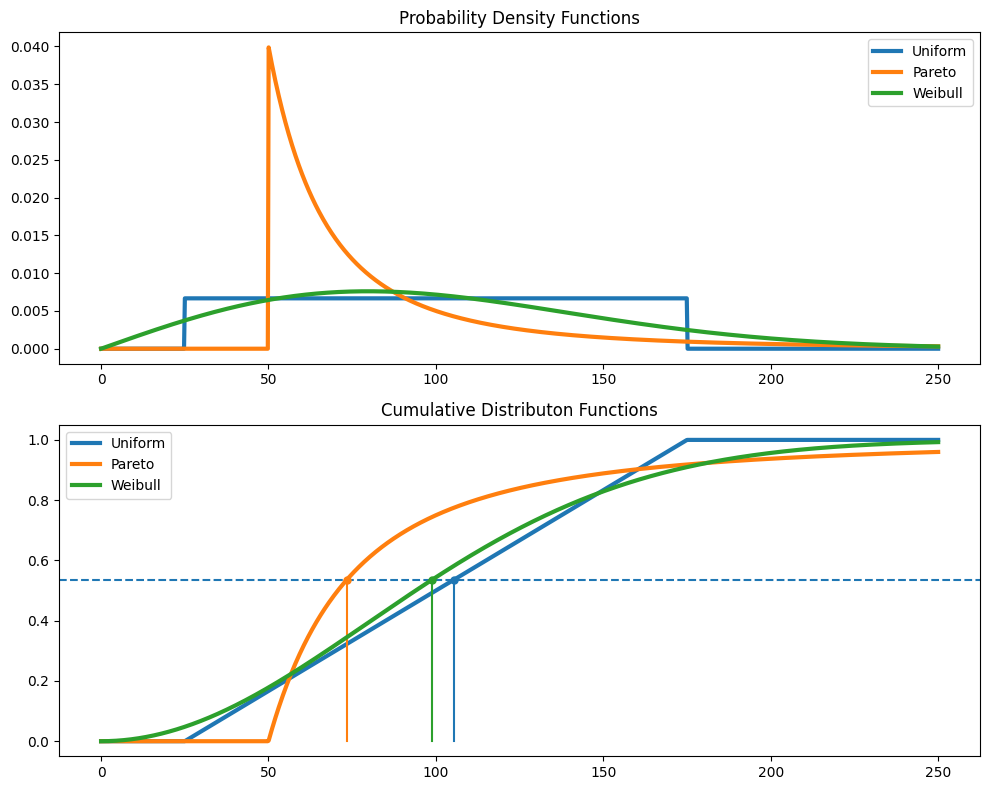

In [38]:
# Setting parameters
c = 10
p = 25
h = 3

# quantile
q = (p - c)/(p + h)

x = np.linspace(0, 250, 1000)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].set_title("Probability Density Functions")
ax[1].set_title("Cumulative Distributon Functions")
ax[1].axhline(q, linestyle='--')

def plot_distribution(name, distribution, q):
    
    # find optimal solution using a distribution's quantile function (i.e., ppf in scipy.stats)
    x_opt = distribution.ppf(q)
    print(f"\nMean of {name} distribution = {distribution.mean()}")    
    print(f"Optimal solution for {name} distribution = {x_opt:0.2f}\n")
    
    # show pdf, cdf, and graphical solution
    c = ax[0].plot(x, distribution.pdf(x), lw=3, label=name)[0].get_color()
    ax[1].plot(x, distribution.cdf(x), color=c, lw=3, label=name)
    ax[1].plot([x_opt]*2, [0, q], color=c)
    ax[1].plot(x_opt, q, '.', color=c, ms=10)
      
plot_distribution("Uniform", stats.uniform(loc=25, scale=150), q)
plot_distribution("Pareto", stats.pareto(scale=50, b=2), q)
plot_distribution("Weibull", stats.weibull_min(scale=112.838, c=2), q)
   
ax[0].legend()
ax[1].legend()
fig.tight_layout()

## Deterministic Solution for Mean Demand

Find the optimal solution of the deterministic LP model obtained by assuming the demand is fixed $\xi=\bar{\xi}$ and equal to the average demand $\bar{\xi} = \mathbb E \xi = 100$.

In [14]:
# problem data
c = 10
p = 25
h = 3

m = pyo.ConcreteModel()

# key parameter for possible parametric study
m.mean_demand = pyo.Param(initialize=100, mutable=True)

# first stage variables and expressions
m.x = pyo.Var(domain=pyo.NonNegativeReals)

@m.Expression()
def first_stage_profit(m):
    return -c * m.x

# second stage variables, constraints, and expressions
m.y = pyo.Var(domain=pyo.NonNegativeReals)
m.z = pyo.Var(domain=pyo.NonNegativeReals)

@m.Constraint()
def cant_sell_fish_i_dont_have(m):
    return m.y <= m.mean_demand

@m.Constraint()
def fish_do_not_disappear(m):
    return m.y + m.z == m.x

@m.Expression()
def second_stage_profit(m):
    return p * m.y - h * m.z

# objective
@m.Objective(sense=pyo.maximize)
def total_profit(m):
    return m.first_stage_profit + m.second_stage_profit

result = pyo.SolverFactory('cbc').solve(m)

assert result.solver.status == "ok"
assert result.solver.termination_condition == "optimal"

print(f"Optimal solution for determistic demand equal to {m.mean_demand} = {m.x():.1f} tons")
print(f"Optimal deterministic profit = {m.total_profit():.0f}€")


Optimal solution for determistic demand equal to mean_demand = 100.0 tons
Optimal deterministic profit = 1500€


## Profits resulting using mean demand

We now assess how well we perform taking the average demand as input for each of the three demand distributions above.

For a fixed decision variable $x=100$, approximate the expected net profit of the seafood distribution center for each of the three distributions above using the Sample Average Approximation method with $N=2500$ points. More specifically, generate $N=2500$ samples from the considered distribution and solve the extensive form of the stochastic LP resulting from those $N=2500$ scenarios.

In [35]:
# SAA of the two-stage stochastic LP to calculate the expected profit when buying the average

def NaiveSeafoodStockSAA(N, sample, distributiontype):

    model = pyo.ConcreteModel()

    def indices_rule(model):
        return range(N)
    model.indices = pyo.Set(initialize=indices_rule)
    model.xi = pyo.Param(model.indices, initialize=dict(enumerate(sample)))

    # first stage variable
    model.x = 100.0 #bought

    def first_stage_profit(model):
        return -c * model.x

    model.first_stage_profit = pyo.Expression(rule=first_stage_profit)

    # second stage variables
    model.y = pyo.Var(model.indices, within=pyo.NonNegativeReals) #sold
    model.z = pyo.Var(model.indices, within=pyo.NonNegativeReals) #unsold to be stored in cold warehouse 

    # second stage constraints
    model.cantsoldthingsfishdonthave = pyo.ConstraintList()
    model.fishdonotdisappear = pyo.ConstraintList()
    for i in model.indices:
        model.cantsoldthingsfishdonthave.add(expr=model.y[i] <= model.xi[i])
        model.fishdonotdisappear.add(expr=model.y[i] + model.z[i] == model.x)

    def second_stage_profit(model):
        return sum([p * model.y[i] - h * model.z[i] for i in model.indices])/float(N)

    model.second_stage_profit = pyo.Expression(rule=second_stage_profit)

    def total_profit(model):
        return model.first_stage_profit + model.second_stage_profit

    model.total_expected_profit = pyo.Objective(rule=total_profit, sense=pyo.maximize)

    result = pyo.SolverFactory('cbc').solve(model)

    print(f'Approximate expected optimal profit when using the average x=100 with {distributiontype} demand: {model.total_expected_profit():.2f}€')
    
    return model.total_expected_profit()

np.random.seed(0)
N = 7500

samples = np.random.uniform(low=25.0, high=175.0, size=N)
naiveprofit_uniform = NaiveSeafoodStockSAA(N, samples, 'uniform')

shape = 2
xm = 50
samples = (np.random.pareto(a=shape, size=N) + 1) *  xm
naiveprofit_pareto = NaiveSeafoodStockSAA(N, samples, 'Pareto')

shape=2
scale=113
samples = scale*np.random.weibull(a=shape, size=N)
naiveprofit_weibull = NaiveSeafoodStockSAA(N, samples, 'Weibull')

Approximate expected optimal profit when using the average x=100 with uniform demand: 966.36€
Approximate expected optimal profit when using the average x=100 with Pareto demand: 787.71€
Approximate expected optimal profit when using the average x=100 with Weibull demand: 910.55€


## SAA with 5000 samples

Solve approximately the stock optimization problem for each of the three distributions above using the Sample Average Approximation method with $N=5000$ points. More specifically, generate $N=5000$ samples from the considered distribution and solve the extensive form of the stochastic LP resulting from those $N=5000$ scenarios. For each of the three distribution, compare the optimal expected profit with that obtained before and calculate the value of the stochastic solution (VSS).

In [107]:
# Two-stage stochastic LP for uniform distribution

def SeafoodStockSAA(N, sample, distributiontype, printflag=True):

    model = pyo.ConcreteModel()

    def indices_rule(model):
        return range(N)
    model.indices = pyo.Set(initialize=indices_rule)
    model.xi = pyo.Param(model.indices, initialize=dict(enumerate(sample)))

    # first stage variable
    model.x = pyo.Var(within=pyo.NonNegativeReals) #bought

    def first_stage_profit(model):
        return -c * model.x

    model.first_stage_profit = pyo.Expression(rule=first_stage_profit)

    # second stage variables
    model.y = pyo.Var(model.indices, within=pyo.NonNegativeReals) #sold
    model.z = pyo.Var(model.indices, within=pyo.NonNegativeReals) #unsold to be returned 

    # second stage constraints
    model.cantsoldfishidonthave = pyo.ConstraintList()
    model.fishdonotdisappear = pyo.ConstraintList()
    for i in model.indices:
        model.cantsoldfishidonthave.add(expr=model.y[i] <= model.xi[i])
        model.fishdonotdisappear.add(expr=model.y[i] + model.z[i] == model.x)

    def second_stage_profit(model):
        return sum([p * model.y[i] - h * model.z[i] for i in model.indices])/float(N)

    model.second_stage_profit = pyo.Expression(rule=second_stage_profit)

    def total_profit(model):
        return model.first_stage_profit + model.second_stage_profit

    model.total_expected_profit = pyo.Objective(rule=total_profit, sense=pyo.maximize)

    result = pyo.SolverFactory('cbc').solve(model)
    
    if printflag:
        print(f"Approximate solution in the case of {distributiontype} distribution using N={N:.0f} samples")
        print(f"Solver status: {result.solver.status}, {result.solver.termination_condition}")
        print(f"Approximate optimal solution: x = {model.x.value:.2f} tons")
        print(f"Approximate expected optimal profit: {model.total_expected_profit():.2f}€")
    
    return model.total_expected_profit(), model.x.value

np.random.seed(1)
N = 5000

samples = np.random.uniform(low=25.0, high=175.0, size=N)
smartprofit_uniform, x = SeafoodStockSAA(N, samples, 'uniform')
print(f"Value of the stochastic solution: {smartprofit_uniform:.2f}-{naiveprofit_uniform:.2f} = {smartprofit_uniform-naiveprofit_uniform:.2f}€\n")

shape = 2
xm = 50
samples = (np.random.pareto(a=shape, size=N) + 1) *  xm
smartprofit_pareto, x = SeafoodStockSAA(N, samples, 'Pareto')
print(f"Value of the stochastic solution: {smartprofit_pareto:.2f}-{naiveprofit_pareto:.2f} = {smartprofit_pareto-naiveprofit_pareto:.2f}€\n")

shape = 2
scale = 113
samples = scale*np.random.weibull(a=shape, size=N)
smartprofit_weibull, x = SeafoodStockSAA(N, samples, 'Weibull')
print(f"Value of the stochastic solution: {smartprofit_weibull:.2f}-{naiveprofit_weibull:.2f} = {smartprofit_weibull-naiveprofit_weibull:.2f}€\n")

Approximate solution in the case of uniform distribution using N=5000 samples
Solver status: ok, optimal
Approximate optimal solution: x = 105.82 tons
Approximate expected optimal profit: 979.98€
Value of the stochastic solution: 979.98-966.36 = 13.63€

Approximate solution in the case of Pareto distribution using N=5000 samples
Solver status: ok, optimal
Approximate optimal solution: x = 73.33 tons
Approximate expected optimal profit: 890.72€
Value of the stochastic solution: 890.72-787.71 = 103.00€

Approximate solution in the case of Weibull distribution using N=5000 samples
Solver status: ok, optimal
Approximate optimal solution: x = 100.06 tons
Approximate expected optimal profit: 919.08€
Value of the stochastic solution: 919.08-910.55 = 8.54€



## SAA convergence

We now solve the randomized sampled problem for a different number of samples, with the sample size $N$ increasing from $25$ to $3000$. As we can see, the approximate solutions converge to the theoretical ones as the sample size increases.

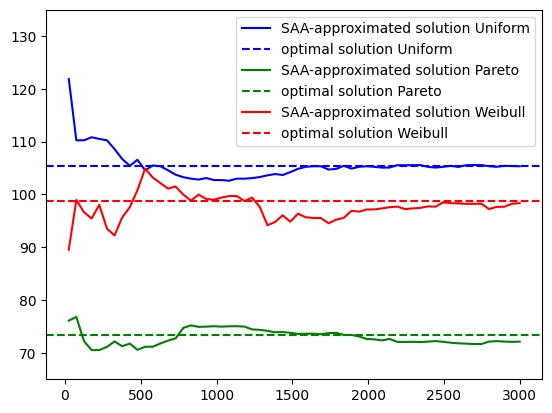

In [109]:
shape = 2
xm = 50
scale = 113
levels = 60

table = np.zeros((levels,7))

for i, N in enumerate(np.linspace(25, 3000, levels, dtype=int)):
    
    np.random.seed(0)
    samples = np.random.uniform(low=25.0, high=175.0, size=N)
    profit_uniform, xu = SeafoodStockSAA(N, samples, 'uniform', False)
    samples = (np.random.pareto(a=shape, size=N) + 1) *  xm
    profit_pareto, xp = SeafoodStockSAA(N, samples, 'Pareto', False)
    samples = scale*np.random.weibull(a=shape, size=N)
    profit_weibull, xw = SeafoodStockSAA(N, samples, 'Weibull', False)
    table[i] = [N, xu, xp, xw, profit_uniform, profit_pareto, profit_weibull]
    
plt.plot(table[:,0],table[:,1], "-b", label='SAA-approximated solution Uniform')
plt.axhline(y=105.36, color='b', linestyle='--', label='optimal solution Uniform')
plt.plot(table[:,0],table[:,2], "-g", label='SAA-approximated solution Pareto')
plt.axhline(y=73.38, color='g', linestyle='--', label='optimal solution Pareto')
plt.plot(table[:,0],table[:,3], "-r", label='SAA-approximated solution Weibull')
plt.axhline(y=98.84, color='r', linestyle='--', label='optimal solution Weibull')
plt.legend(loc="upper right")
plt.ylim(65,135)
plt.show()